In [94]:
import datetime
import time
import numpy as np
import pandas as pd
from packaging import version
from collections import Counter

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical

In [95]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

In [96]:
def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions)))) 

In [97]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

In [98]:
#Loading Data

In [99]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

In [100]:
print('train_images:\t{}'.format(x_train.shape))
print('train_labels:\t{}'.format(y_train.shape))
print('test_images:\t{}'.format(x_test.shape))
print('test_labels:\t{}'.format(y_test.shape))

train_images:	(50000, 32, 32, 3)
train_labels:	(50000, 1)
test_images:	(10000, 32, 32, 3)
test_labels:	(10000, 1)


In [101]:
def get_three_classes(x, y):
    def indices_of(class_id):
        indices, _ = np.where(y == float(class_id))
        return indices

    indices = np.concatenate([indices_of(0), indices_of(1), indices_of(2)], axis=0)
    
    x = x[indices]
    y = y[indices]
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)
    
    x = x[indices]
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y)
    
    return x, y

In [102]:
(train_images, train_labels),(test_images, test_labels)= tf.keras.datasets.cifar10.load_data()

In [103]:
x_preview, y_preview = get_three_classes(train_images, train_labels)
#x_preview, y_preview = get_three_classes(test_images, test_labels)

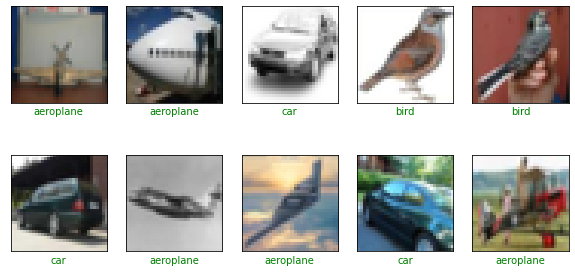

In [104]:
class_names_preview = ['aeroplane', 'car', 'bird']

def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)
    
    x = x[indices]
    y = y[indices]
    p = p[indices]
    
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names_preview[np.argmax(p[i])], color=col)
    plt.show()

show_random_examples(x_preview, y_preview, y_preview)

The labels are an array of integers, ranging from 0 to 9. These correspond to the class of clothing the image represents:

|Label  |Class_  |
|-------|--------|
|0|	airplane     |
|1|	automobile   |
|2|	bird         |
|3|	cat          |
|4|	deer         |
|5|	dog          |
|6|	frog         |
|7|	horse        |
|8|	ship         |
|9|	truck        |

In [105]:
class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

In [106]:
x_train_split, x_valid_split, y_train_split, y_valid_split = train_test_split(x_train
                                                                              ,y_train
                                                                              ,test_size=.1
                                                                              ,random_state=42
                                                                              ,shuffle=True)

In [107]:
print(x_train_split.shape, x_valid_split.shape, x_test.shape)

(45000, 32, 32, 3) (5000, 32, 32, 3) (10000, 32, 32, 3)


In [108]:
x_train_norm = x_train_split/255
x_valid_norm = x_valid_split/255
x_test_norm = x_test/255

In [109]:
results = []

## Experiment 3: CNN with 2 convolution/max pooling layers (no regularization)

In [110]:
model1 = models.Sequential()
model1.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=(32, 32, 3)))
model1.add(layers.MaxPool2D((2, 2),strides=2))
#model1.add(layers.Dropout(0.3))
model1.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=(32, 32, 3)))
model1.add(layers.MaxPool2D((2, 2),strides=2))
#model1.add(layers.Dropout(0.3))
model1.add(layers.Flatten())
model1.add(layers.BatchNormalization())
model1.add(layers.Dense(units=384, activation=tf.nn.relu))
model1.add(layers.Dense(units=10, activation=tf.nn.softmax))

In [111]:
model1.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 30, 30, 512)       14336     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 15, 15, 512)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 13, 13, 256)       1179904   
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 6, 6, 256)         0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 9216)              0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 9216)              36864     
_________________________________________________________________
dense_14 (Dense)             (None, 384)              

In [112]:
model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [113]:
history = model1.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=100
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    tf.keras.callbacks.ModelCheckpoint('/mnt/Assignement2/models/model_{val_accuracy:.4f}.h5', save_best_only=True,
                                        save_weights_only=False, monitor='val_accuracy')]                                                                                                           
                   )

Epoch 1/200
450/450 [==============================] - 5s 11ms/step - loss: 1.2899 - accuracy: 0.5460 - val_loss: 1.8489 - val_accuracy: 0.3626
Epoch 2/200
450/450 [==============================] - 5s 11ms/step - loss: 0.8991 - accuracy: 0.6891 - val_loss: 1.0510 - val_accuracy: 0.6460
Epoch 3/200
450/450 [==============================] - 5s 11ms/step - loss: 0.7077 - accuracy: 0.7560 - val_loss: 2.3766 - val_accuracy: 0.4580
Epoch 4/200
450/450 [==============================] - 5s 11ms/step - loss: 0.5666 - accuracy: 0.8041 - val_loss: 1.4077 - val_accuracy: 0.6038
Epoch 5/200
450/450 [==============================] - 5s 11ms/step - loss: 0.4440 - accuracy: 0.8463 - val_loss: 1.3409 - val_accuracy: 0.6244


In [114]:
loss, accuracy = model1.evaluate(x_test_norm, y_test)
print('test set accuracy: ', accuracy * 100, "%")

313/313 [==============================] - 1s 3ms/step - loss: 1.3327 - accuracy: 0.6282
test set accuracy:  62.81999945640564 %


In [115]:
train_losses = history.history["loss"]
train_accs = history.history["accuracy"]
val_losses = history.history["val_loss"]
val_accs = history.history["val_accuracy"]
epochs = len(train_losses)

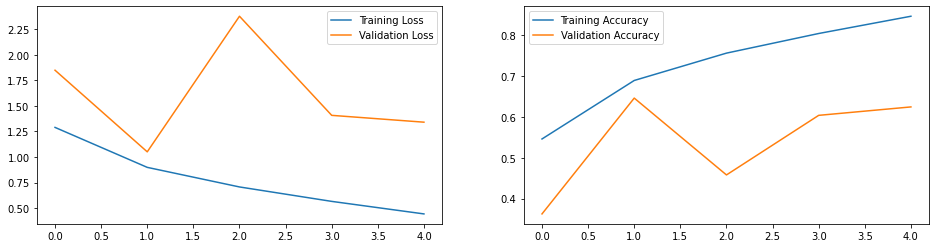

In [116]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([train_losses, train_accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [117]:
result_3 = {"Experiemnt": "Experiment 3: CNN with 2 Conv/MaxPool Layer w/o reg", "Test_Accuracy": accuracy,
            "loss": loss, "Train_Accuracy":train_accs[-1], "Train_Loss":train_losses[-1],
            "Val_Accuracy":val_accs[-1],
            "Val_Loss":val_losses[-1]}
results.append(result_3)

# Result2: Take Experiment 3 – Extract the outputs from 2 filters from the 2 max pooling layers and visualize them in a grid as images. See whether the ‘lighted’ up regions correspond to some features in the original images.

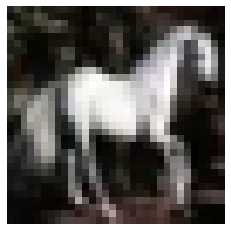

In [161]:
img = test_images[13]
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

plt.imshow(img, cmap='viridis')
plt.axis('off')
plt.show()

In [162]:
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model1.layers[:8]]

In [163]:
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model1.input, outputs=layer_outputs)

In [164]:
layer_outputs

[<tf.Tensor 'conv2d_16/Relu:0' shape=(None, 30, 30, 512) dtype=float32>,
 <tf.Tensor 'max_pooling2d_16/MaxPool:0' shape=(None, 15, 15, 512) dtype=float32>,
 <tf.Tensor 'conv2d_17/Relu:0' shape=(None, 13, 13, 256) dtype=float32>,
 <tf.Tensor 'max_pooling2d_17/MaxPool:0' shape=(None, 6, 6, 256) dtype=float32>,
 <tf.Tensor 'flatten_7/Reshape:0' shape=(None, 9216) dtype=float32>,
 <tf.Tensor 'batch_normalization_7/batchnorm/add_1:0' shape=(None, 9216) dtype=float32>,
 <tf.Tensor 'dense_14/Relu:0' shape=(None, 384) dtype=float32>,
 <tf.Tensor 'dense_15/Softmax:0' shape=(None, 10) dtype=float32>]

In [165]:
activations = activation_model.predict(img_tensor)
len(activations)

8

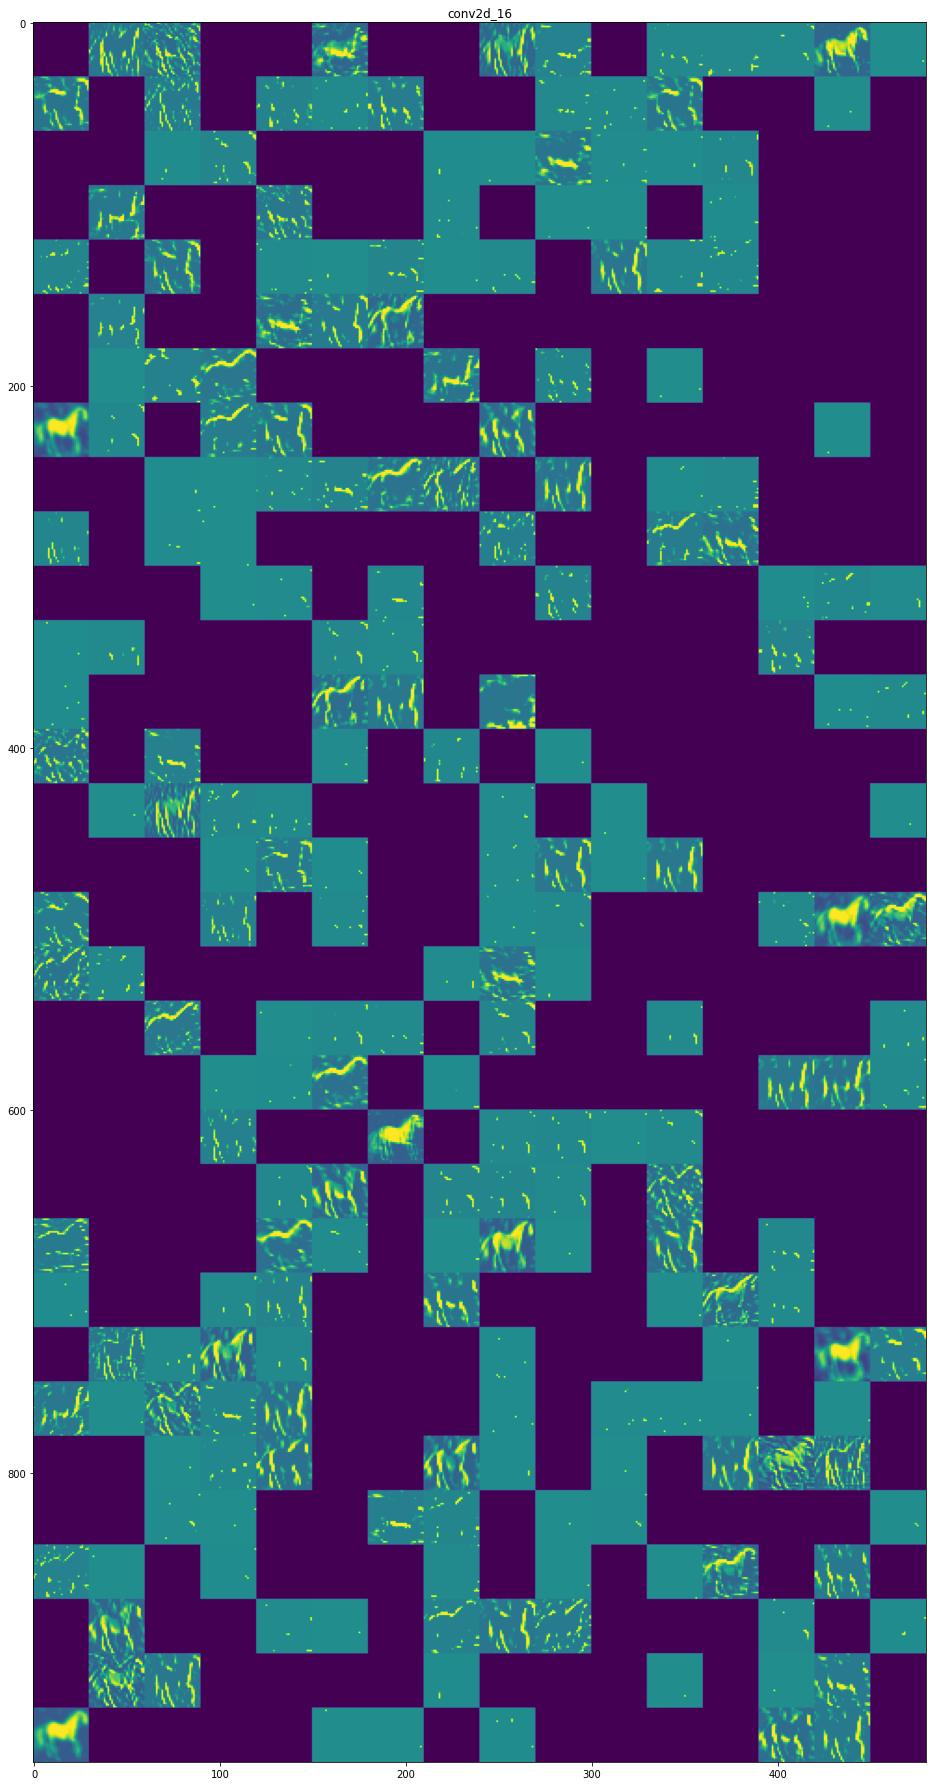

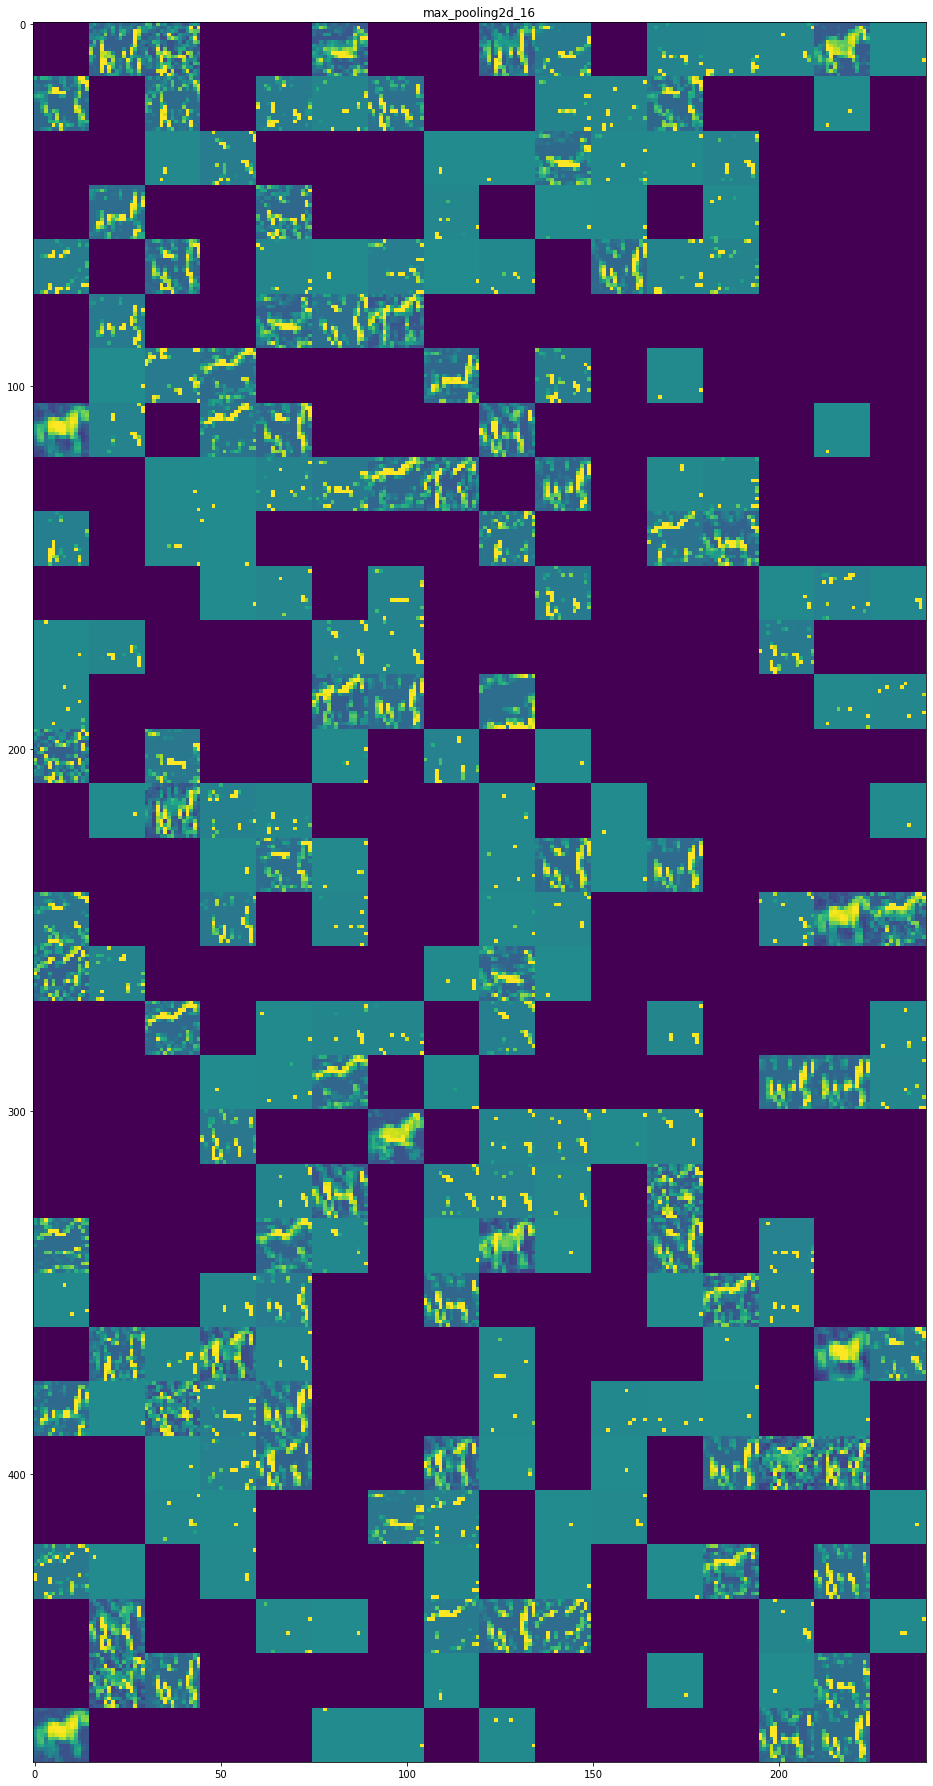

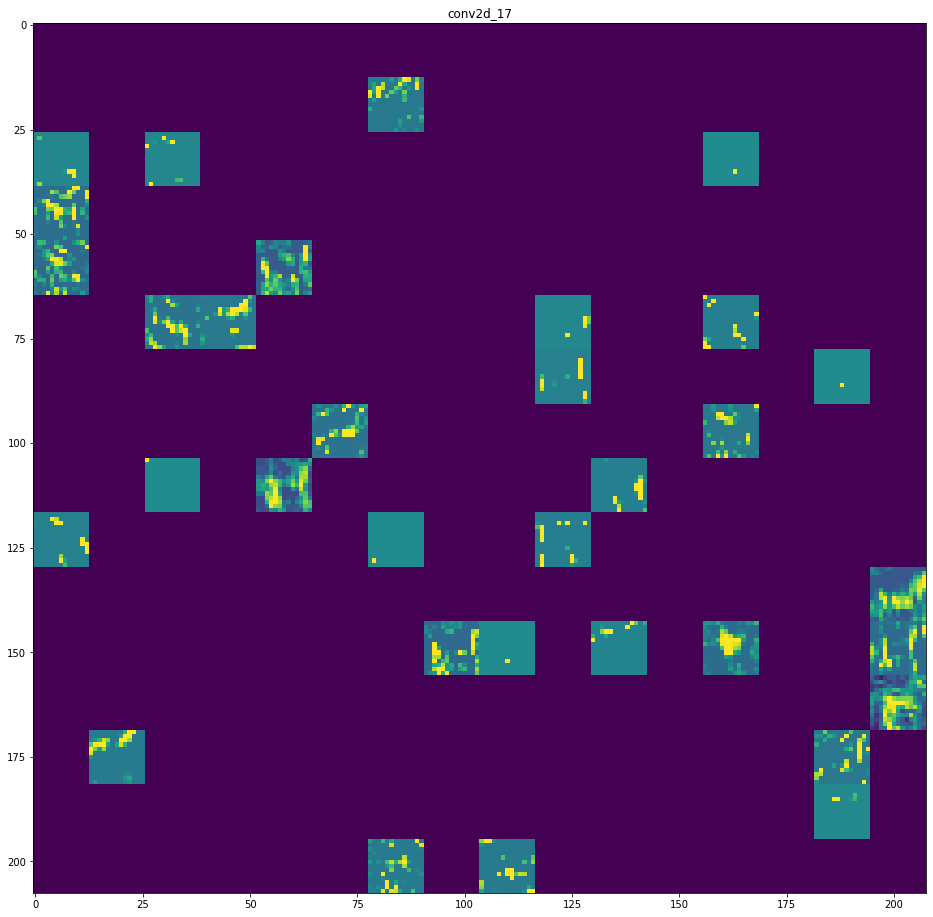

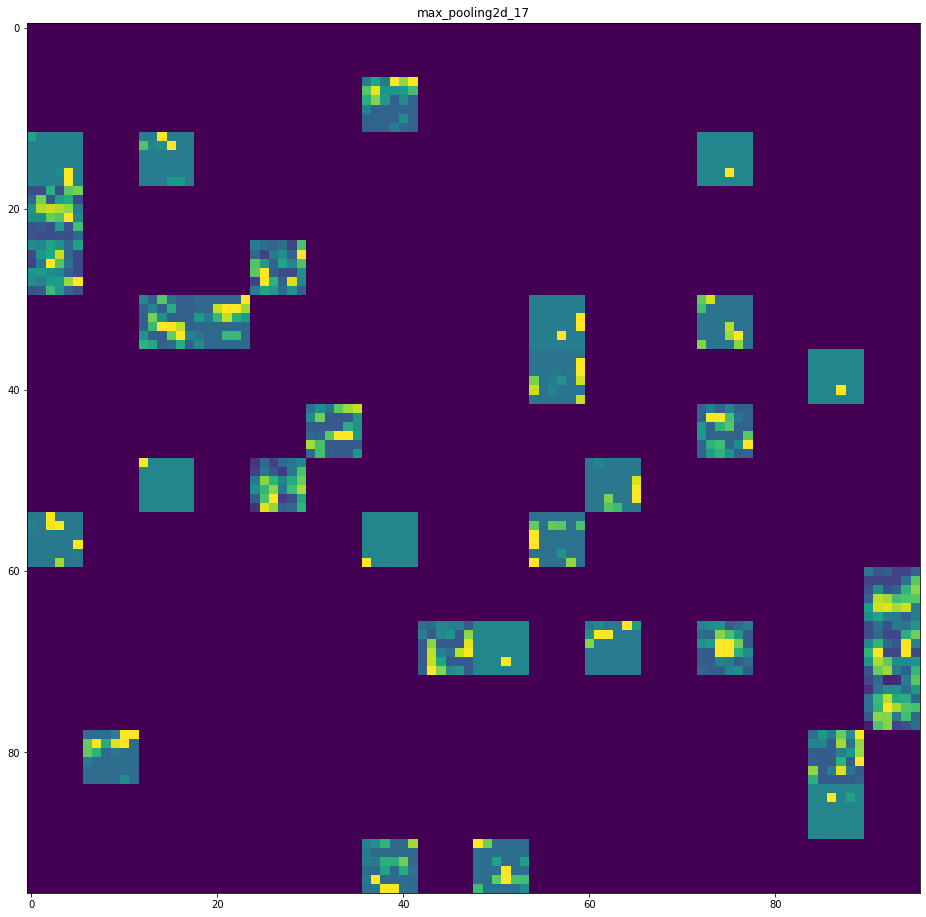

In [171]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model1.layers[:4]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    fig = plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    fig.savefig(layer_name+".png", dpi=fig.dpi)
    
plt.show();

## Experiment 4: CNN with 3 convolution/max pooling layers (no regularization)

In [83]:
model1 = models.Sequential()
model1.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=(32, 32, 3)))
model1.add(layers.MaxPool2D((2, 2),strides=2))
#model1.add(layers.Dropout(0.3))
model1.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=(32, 32, 3)))
model1.add(layers.MaxPool2D((2, 2),strides=2))
#model1.add(layers.Dropout(0.3))
model1.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=(32, 32, 3)))
model1.add(layers.MaxPool2D((2, 2),strides=2))
#model1.add(layers.Dropout(0.3))
model1.add(layers.Flatten())
model1.add(layers.BatchNormalization())
model1.add(layers.Dense(units=384, activation=tf.nn.relu))
model1.add(layers.Dense(units=10, activation=tf.nn.softmax))

In [84]:
model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [85]:
history = model1.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=100
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    tf.keras.callbacks.ModelCheckpoint('/mnt/Assignement2/models/model_{val_accuracy:.4f}.h5', save_best_only=True,
                                        save_weights_only=False, monitor='val_accuracy')]                                                                                                           
                   )

Epoch 1/200
450/450 [==============================] - 5s 11ms/step - loss: 1.3603 - accuracy: 0.5136 - val_loss: 1.8112 - val_accuracy: 0.4108
Epoch 2/200
450/450 [==============================] - 5s 11ms/step - loss: 1.0104 - accuracy: 0.6450 - val_loss: 1.6005 - val_accuracy: 0.4992
Epoch 3/200
450/450 [==============================] - 5s 11ms/step - loss: 0.8594 - accuracy: 0.6970 - val_loss: 1.1372 - val_accuracy: 0.6072
Epoch 4/200
450/450 [==============================] - 5s 11ms/step - loss: 0.7514 - accuracy: 0.7370 - val_loss: 1.4677 - val_accuracy: 0.5450
Epoch 5/200
450/450 [==============================] - 5s 11ms/step - loss: 0.6732 - accuracy: 0.7666 - val_loss: 1.2357 - val_accuracy: 0.6106
Epoch 6/200
450/450 [==============================] - 5s 11ms/step - loss: 0.5996 - accuracy: 0.7893 - val_loss: 1.0454 - val_accuracy: 0.6506
Epoch 7/200
450/450 [==============================] - 5s 11ms/step - loss: 0.5406 - accuracy: 0.8101 - val_loss: 1.0537 - val_accuracy:

In [86]:
history_dict = history.history
history_dict.keys()
history_df=pd.DataFrame(history_dict)

In [87]:
train_losses = history.history["loss"]
train_accs = history.history["accuracy"]
val_losses = history.history["val_loss"]
val_accs = history.history["val_accuracy"]
epochs = len(train_losses)

In [88]:
loss, accuracy = model1.evaluate(x_test_norm, y_test)
print('test set accuracy: ', accuracy * 100, "%")

313/313 [==============================] - 1s 3ms/step - loss: 1.2121 - accuracy: 0.7212
test set accuracy:  72.11999893188477 %


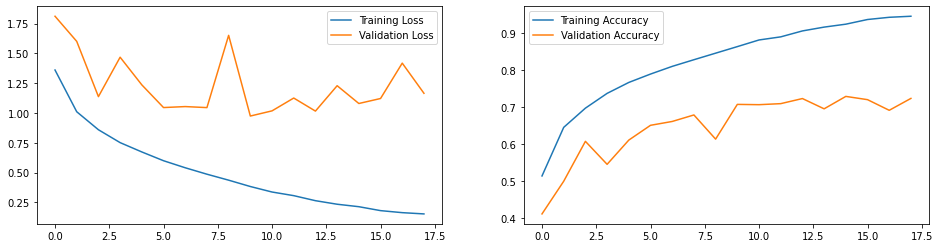

In [89]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([train_losses, train_accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [90]:
val_accs[-1]

0.7233999967575073

In [91]:
result_4 = {"Experiemnt": "Experiment 4: CNN with 3 Conv/MaxPool Layer w/o reg", "Test_Accuracy": accuracy,
            "loss": loss, "Train_Accuracy":train_accs[-1], "Train_Loss":train_losses[-1],
            "Val_Accuracy":val_accs[-1],
           "Val_Loss":val_losses[-1]}
results.append(result_4)

In [92]:
results_df = pd.DataFrame(results)

In [93]:
results_df.to_csv("exp3&4_output.csv", index=False)